In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch
from pathlib import Path
%matplotlib inline
import joblib
import seaborn as sns
sns.set(font_scale=1.2)
from scipy.integrate import simps


In [2]:
# List All Data
spath = 'DATA/ALL/'

p = Path(spath)
dpath = [x for x in p.iterdir() if x.is_file() and x.suffix == '.txt']
dpath = [x.as_posix() for x in dpath]

dpath = sorted(dpath)

In [3]:
# Filter Design

# Bandpass filter
def bandpass(start, stop, data, fs = 125):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(4, bp_Hz / (fs / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

# Notch filter
def notch(val, data, fs= 125):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin

# FFT Function for checking
def fft(data, fs):
    L = len(data)
    freq = np.linspace(0.0, 1.0 / (2.0 * fs **-1), L // 2)
    yi = np.fft.fft(data)[1:]
    y = yi[range(int(L / 2))]
    return freq, abs(y)

In [4]:
# Load data to pandas
def openbci_to_pandas(path):
    """
    Turn OpenBCI data to Pandas DataFrame.
    Slice channels data only.
    Rename the channels name

    Parameters
    ----------
    path : String
           The file location
    
    Returns
    --------
    df  : DataFrame
    """
    df = pd.read_csv(path, skiprows=4)
    df = df.iloc[:,1:17]
    df.columns = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T3', 'T4','P3','P4']

    return df


In [5]:
# Load all data to pandas
all_data = []
for i in dpath:
    df = openbci_to_pandas(i)
    all_data.append(df)

print(len(all_data))

15


In [6]:
all_data[6].shape

(12198, 16)

In [7]:
# fs, notch, band settings
fs_notch = 50
fs = 125

In [8]:
# Subject 2 Only
s3 = [7, 8, 9, 10]

# notch filter for multiple data
s3_notch = []

for i in s3:
    notch_ch = []
    data = all_data[i]
    
    for j in range(data.shape[1]):
        notch_ch.append(notch(fs_notch,data.iloc[:,j], fs))
    
    notch_ch = np.array(notch_ch)
    s3_notch.append(notch_ch)

In [9]:
s3_notch[2].shape

(16, 16479)

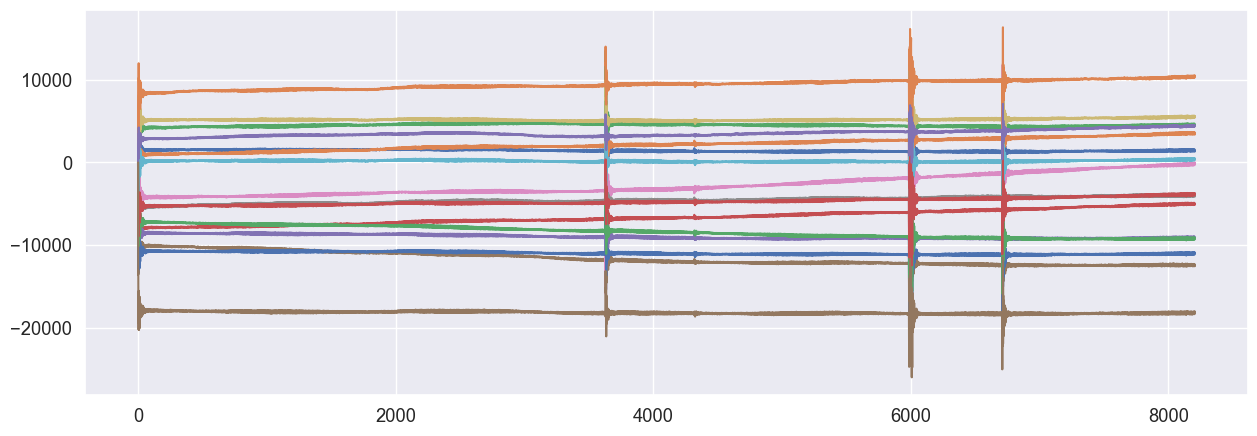

In [10]:
plt.figure(figsize=(15,5))
for i in range(len(s3_notch[0])):
    plt.plot(s3_notch[0][i])

(0.0, 100.0)

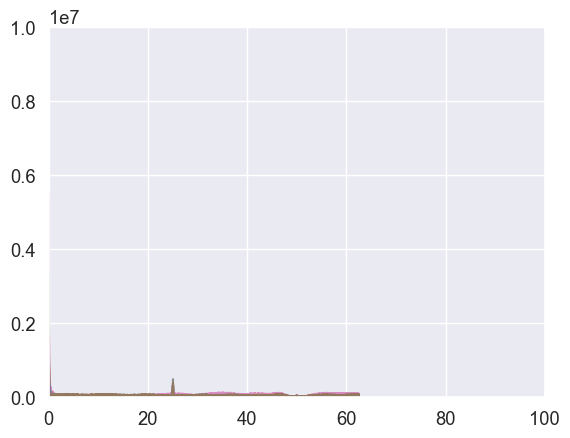

In [11]:
# check fft of applied notch
for i in range(len(s3_notch[0])):
    freq, y = fft(s3_notch[0][i], fs)
    plt.plot(freq, y)
plt.ylim(0, 1e7)
plt.xlim(0,100)

In [12]:
#applied bandpass filter = 5-50 and notch = 60
band = (1,50)

s3_bandpass_notch = []

for i in range(len(s3_notch)):
    bandpass_notch_channels = []
    data_notch = s3_notch[i]

    for j in range(len(data_notch)):
        bandpass_notch_channels.append(bandpass(band[0],band[1], data_notch[j], fs))
    
    bandpass_notch_channels = np.array(bandpass_notch_channels)
    s3_bandpass_notch.append(bandpass_notch_channels)

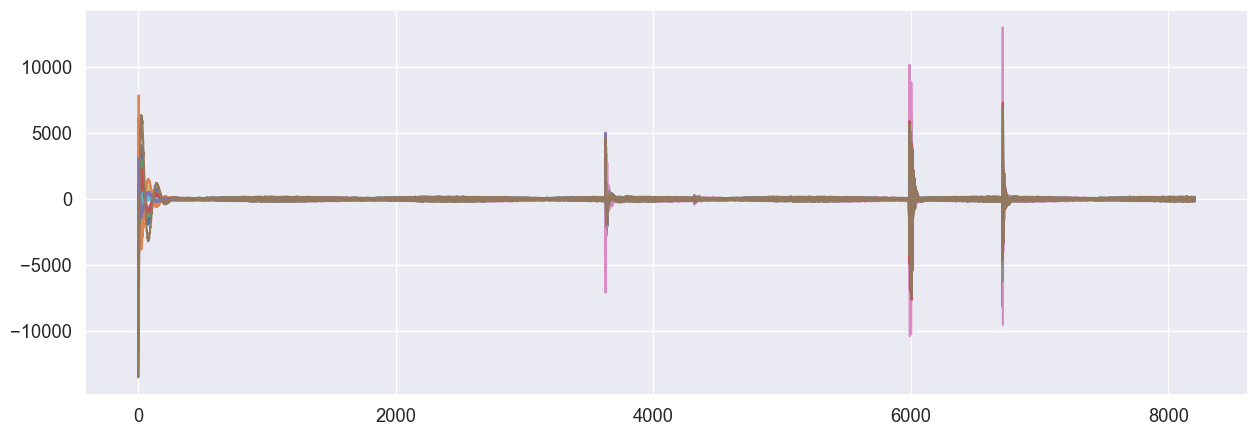

In [13]:
plt.figure(figsize=(15,5))
for i in range(len(s3_bandpass_notch[0])):
    plt.plot(s3_bandpass_notch[0][i])

In [14]:
s3_bandpass_notch[0].shape

(16, 8206)

In [15]:
# Cut-off begining of the signal
def cut_off(data, begin, duration, fs):
    duration = (duration * fs)

    if begin != 0:
        begin = (begin * fs) - 1
    else:
        begin = 0 + ((begin * fs) - 1)

    cut_data = data[:,begin:begin+duration]
    
    return cut_data

In [16]:
s3_bandpass_notch_sliced = []

for i in range(len(s3_bandpass_notch)):
    slice_data = cut_off(s3_bandpass_notch[i], 3, 60, fs)
    s3_bandpass_notch_sliced.append(slice_data)

In [17]:
s3_bandpass_notch_sliced[0].shape

(16, 7500)

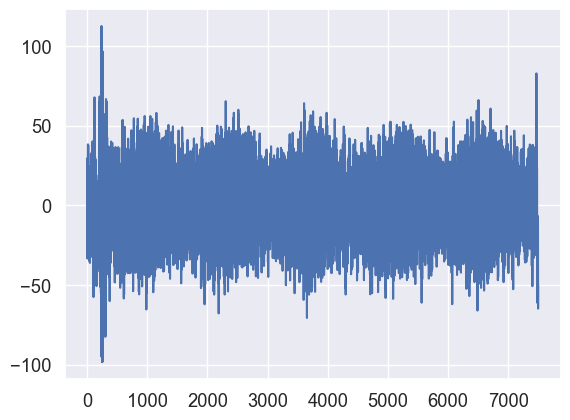

In [18]:
plt.plot(s3_bandpass_notch_sliced[3][0])

In [19]:
joblib.dump(s3_bandpass_notch_sliced, 's3_cutoff.pkl')

['s3_cutoff.pkl']

In [20]:
s3_bandpass_notch_sliced = joblib.load('s3_cutoff.pkl')

In [21]:
cols = ["Fp1", "Fp2", "C3", "C4", "T5", "T6", "O1", "O2", "F7", "F8", "F3", "F4", "T3", "T4", "P3", "P4"]

In [22]:
# Perform bandpass on each signal each state
delta = (1,4)
tetha = (4,8)
alpha = (8,14)
beta = (14,30)
gamma = (30,50)

# Resting Stage

In [23]:
# Stage 1 - Resting State
delta_stage1 = []
tetha_stage1 = []
alpha_stage1 = []
beta_stage1 = []
gamma_stage1 = []
for i in range(s3_bandpass_notch_sliced[0].shape[0]):
    freqs, psd = welch(s3_bandpass_notch_sliced[0][i], nperseg=125, noverlap=0.5, fs=125)
    
    # Band Range
    idx_delta = np.logical_and(freqs >= delta[0], freqs <= delta[1])
    idx_tetha = np.logical_and(freqs >= tetha[0], freqs <= tetha[1])
    idx_alpha = np.logical_and(freqs >= alpha[0], freqs <= alpha[1])
    idx_beta = np.logical_and(freqs >= beta[0], freqs <= beta[1])
    idx_gamma = np.logical_and(freqs >= gamma[0], freqs <= gamma[1])
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    tetha_power = simps(psd[idx_tetha], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    gamma_power = simps(psd[idx_gamma], dx=freq_res)
    
    # Relative power
    total_power = simps(psd, dx=freq_res)
    delta_rel_power = delta_power / total_power
    tetha_rel_power = tetha_power / total_power
    alpha_rel_power = alpha_power / total_power
    beta_rel_power = beta_power / total_power
    gamma_rel_power = gamma_power / total_power
    
    delta_stage1.append(delta_rel_power)
    tetha_stage1.append(tetha_rel_power)
    alpha_stage1.append(alpha_rel_power)
    beta_stage1.append(beta_rel_power)
    gamma_stage1.append(gamma_rel_power)

In [24]:
bands_stage1 = {
    "Delta" : delta_stage1,
    "Tetha" : tetha_stage1,
    "Alpha" : alpha_stage1,
    "Beta" : beta_stage1,
    "Gamma" : gamma_stage1
}

df_bands_stage1 = pd.DataFrame(bands_stage1, index=cols)

In [26]:
df_bands_stage1.head()

,Delta,Tetha,Alpha,Beta,Gamma
Fp1,0.010484,0.003233,0.030205,0.522219,0.421505
Fp2,0.011238,0.003567,0.029094,0.512622,0.430872
C3,0.010074,0.003156,0.027594,0.517528,0.429102
C4,0.011527,0.003284,0.026093,0.559406,0.387698
T5,0.009835,0.003062,0.023501,0.517136,0.433983


<function matplotlib.pyplot.show(close=None, block=None)>

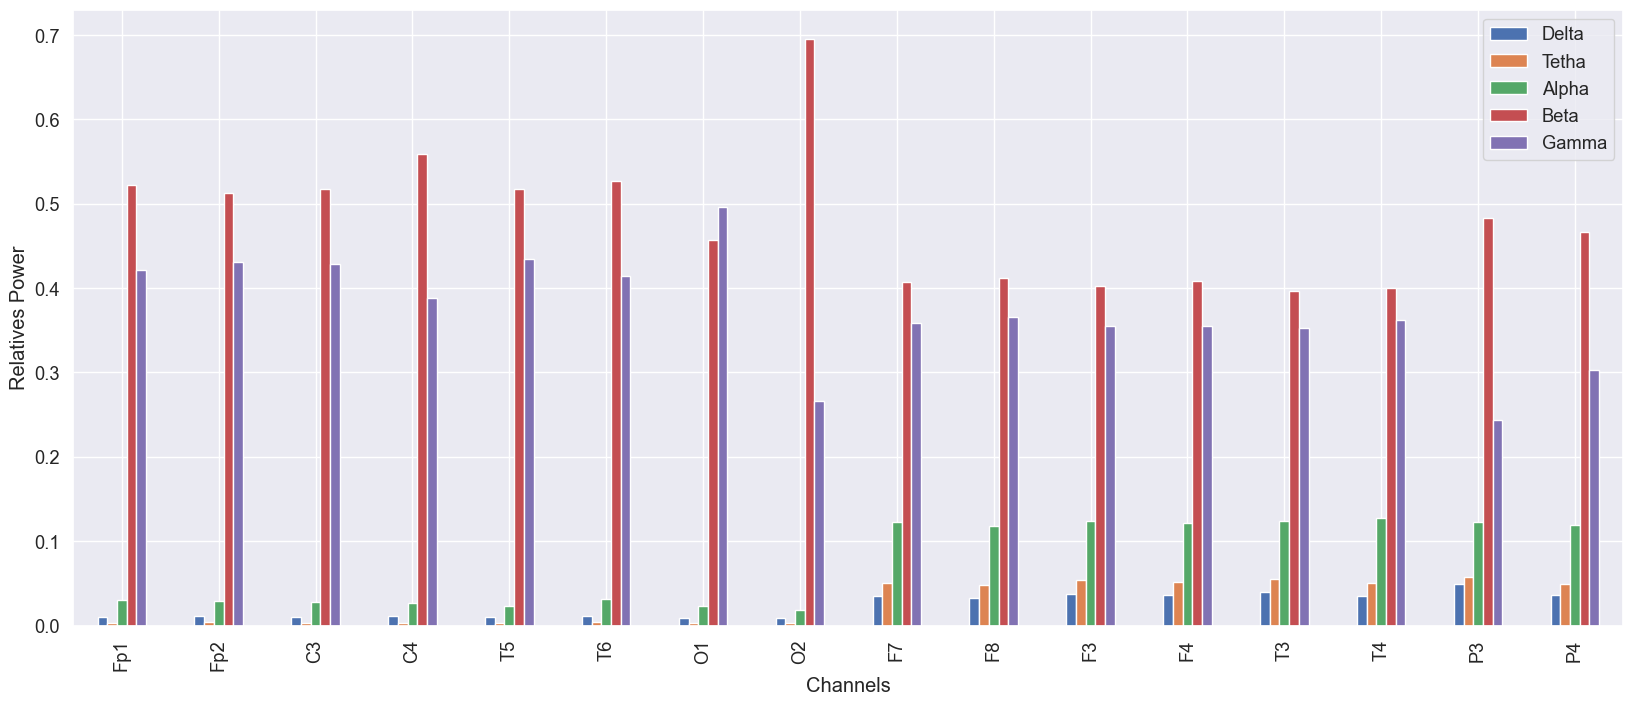

In [27]:
df_bands_stage1.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Channels')
plt.ylabel('Relatives Power')
plt.show

In [28]:
# Mean Channles Values
mean_delta_stage1 = np.mean(delta_stage1)
mean_tetha_stage1 = np.mean(tetha_stage1)
mean_alpha_stage1 = np.mean(alpha_stage1)
mean_beta_stage1 = np.mean(beta_stage1)
mean_gamma_stage1 = np.mean(gamma_stage1)

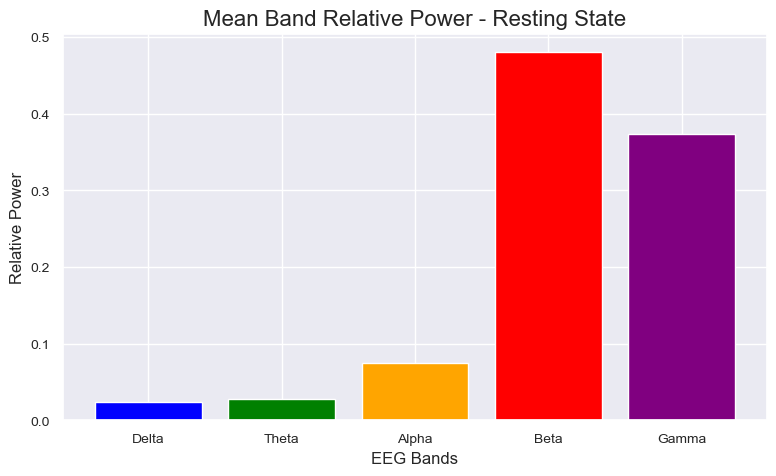

In [29]:
# Data
categories = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
values = [mean_delta_stage1, mean_tetha_stage1, mean_alpha_stage1, mean_beta_stage1, mean_gamma_stage1]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding labels and title
plt.title("Mean Band Relative Power - Resting State", fontsize=16)
plt.xlabel("EEG Bands", fontsize=12)
plt.ylabel("Relative Power", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# Go / NoGo

In [30]:
# Stage 2 - Go / NoGo
delta_stage2 = []
tetha_stage2 = []
alpha_stage2 = []
beta_stage2 = []
gamma_stage2 = []
for i in range(s3_bandpass_notch_sliced[1].shape[0]):
    freqs, psd = welch(s3_bandpass_notch_sliced[1][i], nperseg=125, noverlap=0.5, fs=125)
    
    # Band Range
    idx_delta = np.logical_and(freqs >= delta[0], freqs <= delta[1])
    idx_tetha = np.logical_and(freqs >= tetha[0], freqs <= tetha[1])
    idx_alpha = np.logical_and(freqs >= alpha[0], freqs <= alpha[1])
    idx_beta = np.logical_and(freqs >= beta[0], freqs <= beta[1])
    idx_gamma = np.logical_and(freqs >= gamma[0], freqs <= gamma[1])
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    tetha_power = simps(psd[idx_tetha], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    gamma_power = simps(psd[idx_gamma], dx=freq_res)
    
    # Relative power
    total_power = simps(psd, dx=freq_res)
    delta_rel_power = delta_power / total_power
    tetha_rel_power = tetha_power / total_power
    alpha_rel_power = alpha_power / total_power
    beta_rel_power = beta_power / total_power
    gamma_rel_power = gamma_power / total_power
    
    delta_stage2.append(delta_rel_power)
    tetha_stage2.append(tetha_rel_power)
    alpha_stage2.append(alpha_rel_power)
    beta_stage2.append(beta_rel_power)
    gamma_stage2.append(gamma_rel_power)

In [31]:
bands_stage2 = {
    "Delta" : delta_stage2,
    "Tetha" : tetha_stage2,
    "Alpha" : alpha_stage2,
    "Beta" : beta_stage2,
    "Gamma" : gamma_stage2
}

df_bands_stage2 = pd.DataFrame(bands_stage2, index=cols)

In [32]:
df_bands_stage2.head()

,Delta,Tetha,Alpha,Beta,Gamma
Fp1,0.027415,0.035476,0.042059,0.327417,0.556292
Fp2,0.028214,0.035238,0.042146,0.325093,0.557580
C3,0.027509,0.034965,0.042358,0.325556,0.558064
C4,0.027257,0.036152,0.041737,0.331218,0.552594
T5,0.027366,0.034997,0.042350,0.326143,0.557690


<function matplotlib.pyplot.show(close=None, block=None)>

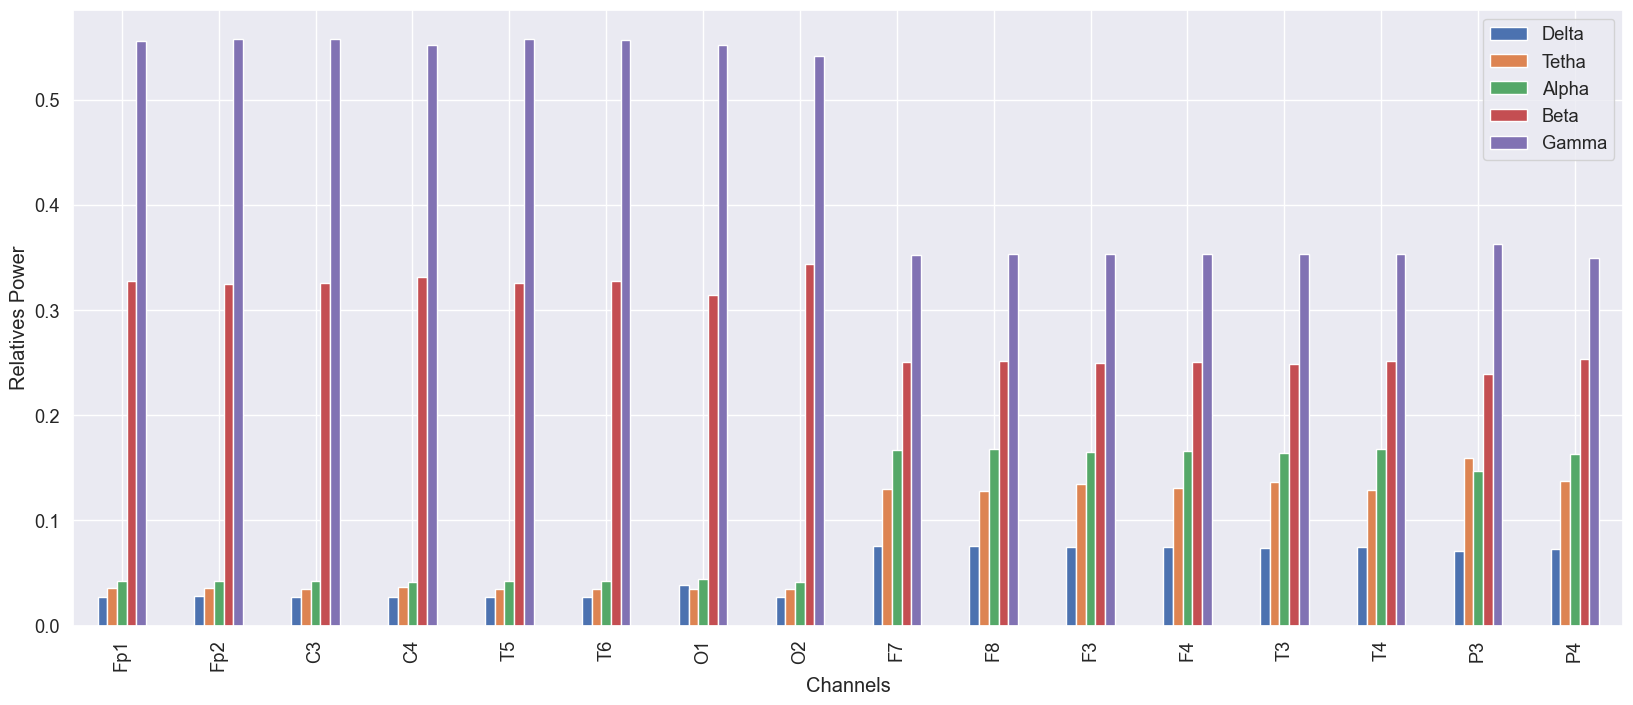

In [33]:
df_bands_stage2.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Channels')
plt.ylabel('Relatives Power')
plt.show

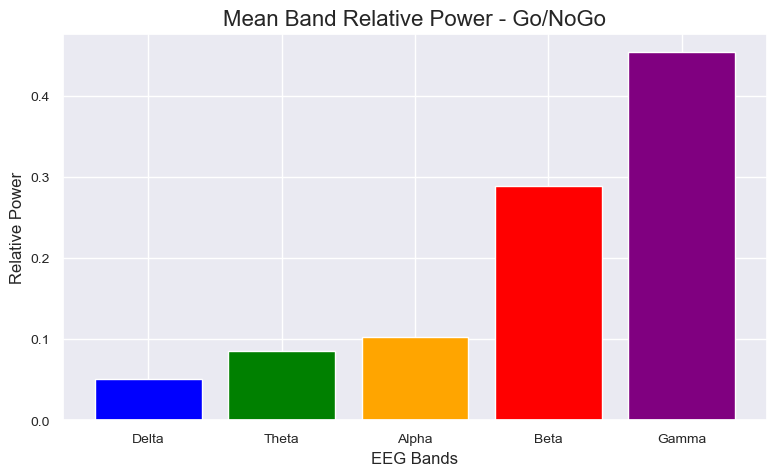

In [34]:
# Mean Channles Values
mean_delta_stage2 = np.mean(delta_stage2)
mean_tetha_stage2 = np.mean(tetha_stage2)
mean_alpha_stage2 = np.mean(alpha_stage2)
mean_beta_stage2 = np.mean(beta_stage2)
mean_gamma_stage2 = np.mean(gamma_stage2)

# Data
categories = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
values = [mean_delta_stage2, mean_tetha_stage2, mean_alpha_stage2, mean_beta_stage2, mean_gamma_stage2]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding labels and title
plt.title("Mean Band Relative Power - Go/NoGo", fontsize=16)
plt.xlabel("EEG Bands", fontsize=12)
plt.ylabel("Relative Power", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Reading

In [35]:
# Stage 3 - Reading
delta_stage3 = []
tetha_stage3 = []
alpha_stage3 = []
beta_stage3 = []
gamma_stage3 = []
for i in range(s3_bandpass_notch_sliced[2].shape[0]):
    freqs, psd = welch(s3_bandpass_notch_sliced[2][i], nperseg=125, noverlap=0.5, fs=125)
    
    # Band Range
    idx_delta = np.logical_and(freqs >= delta[0], freqs <= delta[1])
    idx_tetha = np.logical_and(freqs >= tetha[0], freqs <= tetha[1])
    idx_alpha = np.logical_and(freqs >= alpha[0], freqs <= alpha[1])
    idx_beta = np.logical_and(freqs >= beta[0], freqs <= beta[1])
    idx_gamma = np.logical_and(freqs >= gamma[0], freqs <= gamma[1])
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    tetha_power = simps(psd[idx_tetha], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    gamma_power = simps(psd[idx_gamma], dx=freq_res)
    
    # Relative power
    total_power = simps(psd, dx=freq_res)
    delta_rel_power = delta_power / total_power
    tetha_rel_power = tetha_power / total_power
    alpha_rel_power = alpha_power / total_power
    beta_rel_power = beta_power / total_power
    gamma_rel_power = gamma_power / total_power
    
    delta_stage3.append(delta_rel_power)
    tetha_stage3.append(tetha_rel_power)
    alpha_stage3.append(alpha_rel_power)
    beta_stage3.append(beta_rel_power)
    gamma_stage3.append(gamma_rel_power)

In [36]:
bands_stage3 = {
    "Delta" : delta_stage3,
    "Tetha" : tetha_stage3,
    "Alpha" : alpha_stage3,
    "Beta" : beta_stage3,
    "Gamma" : gamma_stage3
}

df_bands_stage3 = pd.DataFrame(bands_stage3, index=cols)

In [37]:
df_bands_stage3.head()

,Delta,Tetha,Alpha,Beta,Gamma
Fp1,0.031764,0.021821,0.036412,0.276021,0.627801
Fp2,0.033194,0.022477,0.038032,0.276948,0.623007
C3,0.033960,0.022202,0.038248,0.277686,0.621835
C4,0.030327,0.021468,0.035437,0.278004,0.628389
T5,0.033374,0.021736,0.038861,0.277467,0.622593


<function matplotlib.pyplot.show(close=None, block=None)>

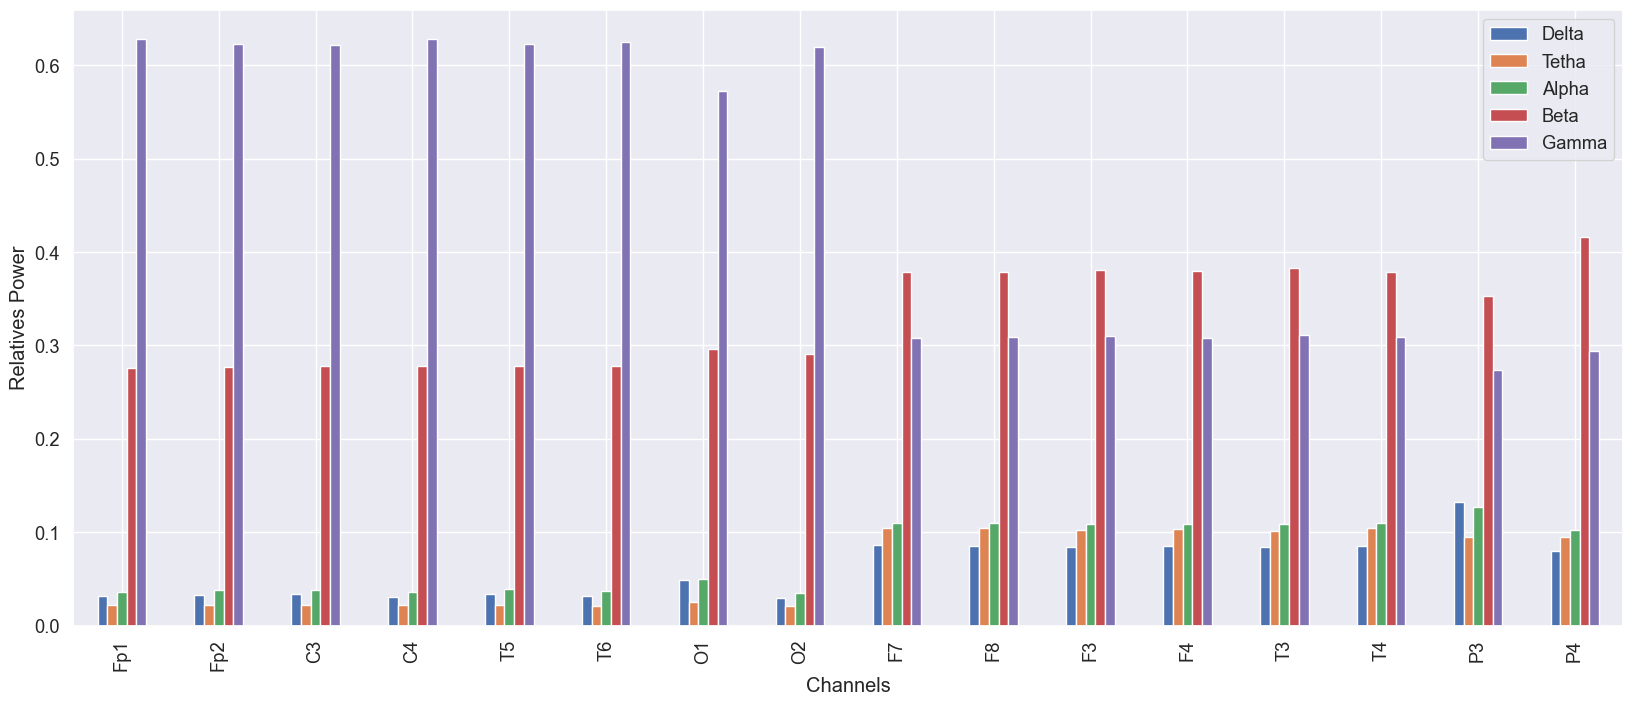

In [38]:
df_bands_stage3.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Channels')
plt.ylabel('Relatives Power')
plt.show

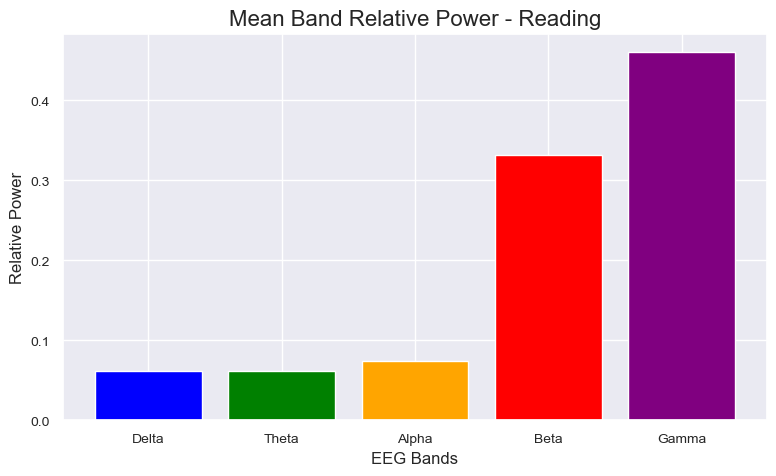

In [39]:
# Mean Channles Values
mean_delta_stage3 = np.mean(delta_stage3)
mean_tetha_stage3 = np.mean(tetha_stage3)
mean_alpha_stage3 = np.mean(alpha_stage3)
mean_beta_stage3 = np.mean(beta_stage3)
mean_gamma_stage3 = np.mean(gamma_stage3)

# Data
categories = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
values = [mean_delta_stage3, mean_tetha_stage3, mean_alpha_stage3, mean_beta_stage3, mean_gamma_stage3]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding labels and title
plt.title("Mean Band Relative Power - Reading", fontsize=16)
plt.xlabel("EEG Bands", fontsize=12)
plt.ylabel("Relative Power", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# VIAT-map

In [40]:
# Stage 4 - VIAT-map
delta_stage4 = []
tetha_stage4 = []
alpha_stage4 = []
beta_stage4 = []
gamma_stage4 = []
for i in range(s3_bandpass_notch_sliced[3].shape[0]):
    freqs, psd = welch(s3_bandpass_notch_sliced[3][i], nperseg=125, noverlap=0.5, fs=125)
    
    # Band Range
    idx_delta = np.logical_and(freqs >= delta[0], freqs <= delta[1])
    idx_tetha = np.logical_and(freqs >= tetha[0], freqs <= tetha[1])
    idx_alpha = np.logical_and(freqs >= alpha[0], freqs <= alpha[1])
    idx_beta = np.logical_and(freqs >= beta[0], freqs <= beta[1])
    idx_gamma = np.logical_and(freqs >= gamma[0], freqs <= gamma[1])
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    tetha_power = simps(psd[idx_tetha], dx=freq_res)
    alpha_power = simps(psd[idx_alpha], dx=freq_res)
    beta_power = simps(psd[idx_beta], dx=freq_res)
    gamma_power = simps(psd[idx_gamma], dx=freq_res)
    
    # Relative power
    total_power = simps(psd, dx=freq_res)
    delta_rel_power = delta_power / total_power
    tetha_rel_power = tetha_power / total_power
    alpha_rel_power = alpha_power / total_power
    beta_rel_power = beta_power / total_power
    gamma_rel_power = gamma_power / total_power
    
    delta_stage4.append(delta_rel_power)
    tetha_stage4.append(tetha_rel_power)
    alpha_stage4.append(alpha_rel_power)
    beta_stage4.append(beta_rel_power)
    gamma_stage4.append(gamma_rel_power)

In [41]:
bands_stage4 = {
    "Delta" : delta_stage4,
    "Tetha" : tetha_stage4,
    "Alpha" : alpha_stage4,
    "Beta" : beta_stage4,
    "Gamma" : gamma_stage4
}

df_bands_stage4 = pd.DataFrame(bands_stage4, index=cols)

In [42]:
df_bands_stage4.head()

,Delta,Tetha,Alpha,Beta,Gamma
Fp1,0.068933,0.022610,0.023698,0.836110,0.027234
Fp2,0.091112,0.023029,0.021617,0.799176,0.029353
C3,0.036767,0.013505,0.016371,0.891793,0.027582
C4,0.078842,0.029743,0.028042,0.772321,0.056157
T5,0.018903,0.006851,0.020181,0.916782,0.028729


<function matplotlib.pyplot.show(close=None, block=None)>

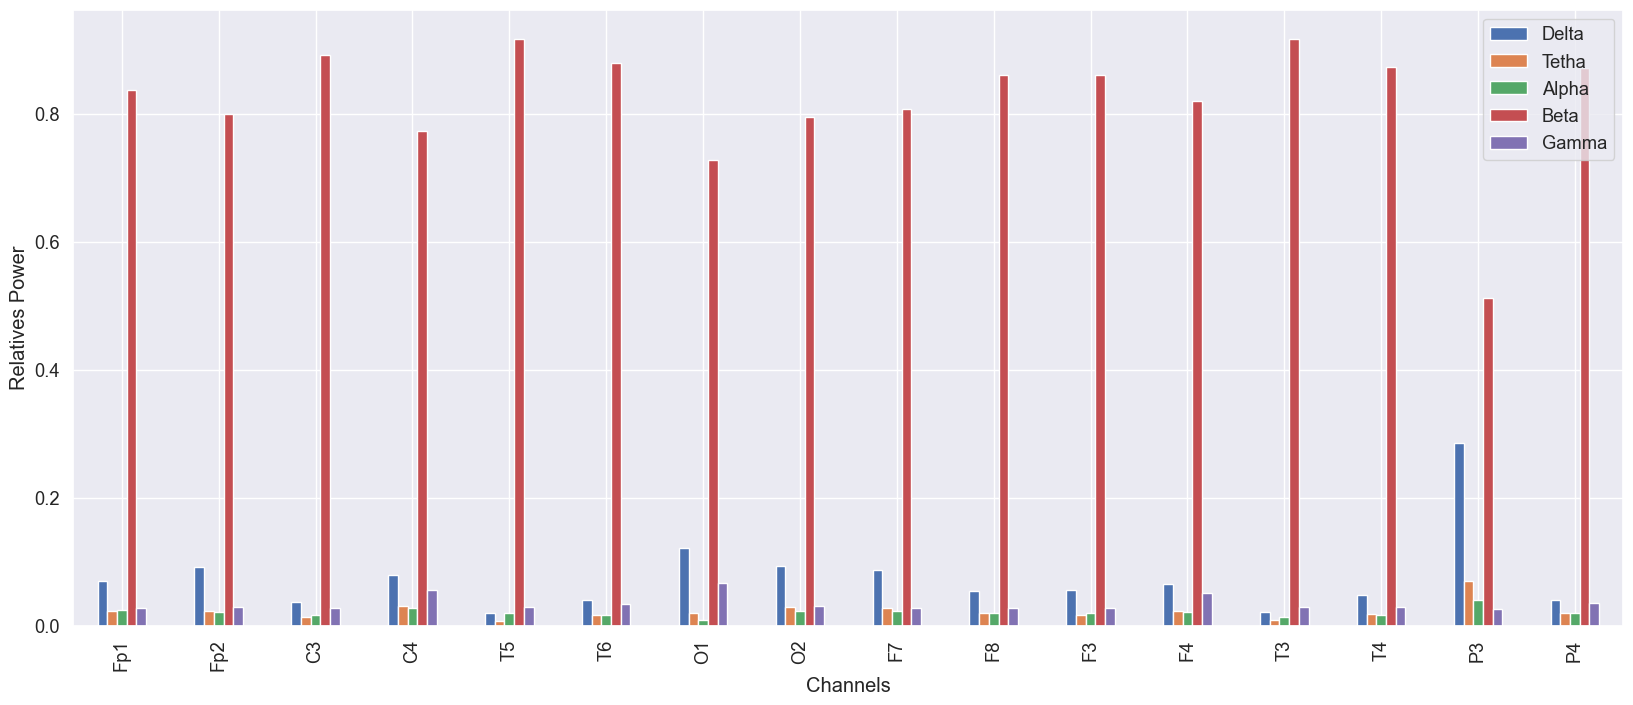

In [43]:
df_bands_stage4.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Channels')
plt.ylabel('Relatives Power')
plt.show

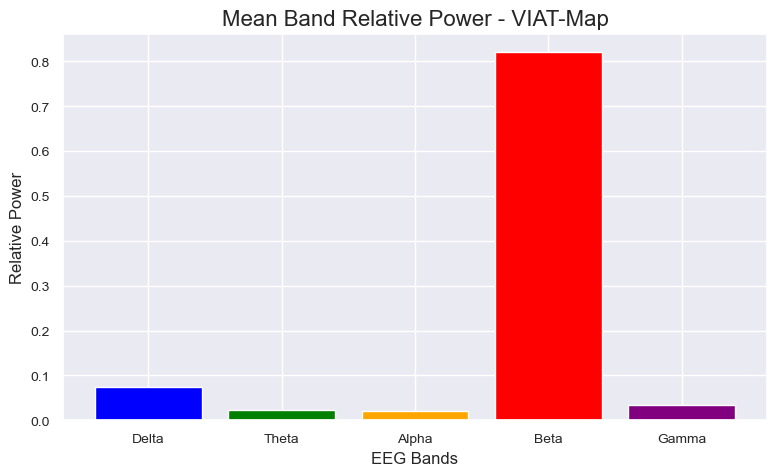

In [44]:
# Mean Channles Values
mean_delta_stage4 = np.mean(delta_stage4)
mean_tetha_stage4 = np.mean(tetha_stage4)
mean_alpha_stage4 = np.mean(alpha_stage4)
mean_beta_stage4 = np.mean(beta_stage4)
mean_gamma_stage4 = np.mean(gamma_stage4)

# Data
categories = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
values = [mean_delta_stage4, mean_tetha_stage4, mean_alpha_stage4, mean_beta_stage4, mean_gamma_stage4]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding labels and title
plt.title("Mean Band Relative Power - VIAT-Map", fontsize=16)
plt.xlabel("EEG Bands", fontsize=12)
plt.ylabel("Relative Power", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Combine Stage

In [45]:
mean_delta_all = [mean_delta_stage1, mean_delta_stage2, mean_delta_stage3, mean_delta_stage4]
mean_tetha_all = [mean_tetha_stage1, mean_tetha_stage2, mean_tetha_stage3, mean_tetha_stage4]
mean_alpha_all = [mean_alpha_stage1, mean_alpha_stage2, mean_alpha_stage3, mean_alpha_stage4]
mean_beta_all = [mean_beta_stage1, mean_beta_stage2, mean_beta_stage3, mean_beta_stage4]
mean_gamma_all = [mean_gamma_stage1, mean_gamma_stage2, mean_gamma_stage3, mean_gamma_stage4]

In [46]:
all_stages = {
    "Delta" : mean_delta_all,
    "Tetha" : mean_tetha_all,
    "Alpha" : mean_alpha_all,
    "Beta" : mean_beta_all,
    "Gamma" : mean_gamma_all
}

df_all_stages = pd.DataFrame(all_stages, index=["Resting", "Go/NoGo", "Reading", "VIAT-Map"])

<function matplotlib.pyplot.show(close=None, block=None)>

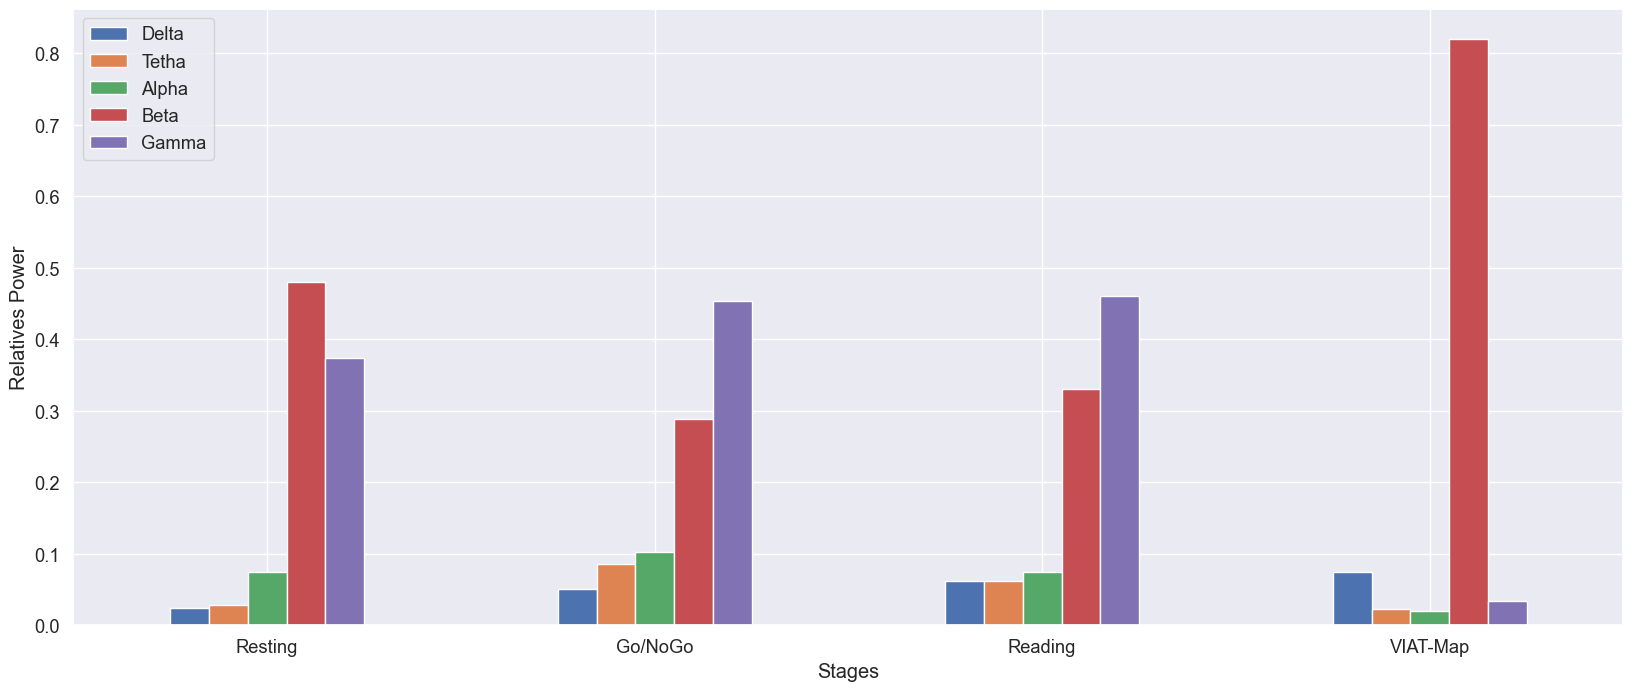

In [47]:
df_all_stages.plot(kind='bar', figsize=(20, 8), rot=0)
plt.xlabel('Stages')
plt.ylabel('Relatives Power')
plt.show